## Sonification Example

Code courtesy of Carrie Filion [(see here)](https://github.com/CarrieFilion/sonic/blob/main/SummerProjects/TriangleMatrixSonification.ipynb)
This example inputs entries from the expansion coefficients matrix and reads them as chords. More info on this will follow in the repository

In [3]:
import matplotlib.pyplot as plt
import strauss
from strauss.sonification import Sonification
from strauss import channels
from strauss.generator import Sampler
from strauss.score import Score
from strauss.generator import Synthesizer
import IPython.display as ipd
from strauss.sources import Events
import os
import numpy as np
import copy

import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import matplotlib.cm as cm

import time

from FLEX_ed import ExpandGalaxies, BeefIt #this is my edited version of the FLEX code - a copy lives in this directory
#BeefIt takes in filename, rscl_initial, mmax_initial, nmax_initial, new_mmax, new_nmax

import ffmpeg #----> only need this if you're trying to make mp3 files. Strauss will save out to wav

In [4]:

fake_matrix = np.zeros([12,7])
fake_matrix[0, 0] = 0.153
fake_matrix[0,1] = 0.001
fake_matrix[1, 0] = 0.043
fake_matrix #input is fake amplitude/modulus matrix

array([[0.153, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.043, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [5]:
test1 = Sampler("op1 synth 8.sf2", sf_preset=0) #this is a soundfont that I made using a synth, which means that it can do any 
#combo of notes and octaves. The 'sf_preset' here is how you would change to a different instrument if you were using a 'normal' soundfont
test1_generator = copy.copy(test1) 
system = "mono" #opting for 'mono' - aka NOT stereo, no spatial info here! Strauss does let you do spatial info - they have some awesome
#examples on their webpage
length = 3 # length, in seconds, of the sound

In [6]:
def map_values_to_notes_one(amplitude_matrix, note_list = np.array(['G','E','C']), fixed_octave = 4,
                                      verbose=0): 
    #this is baking in the assumption that the note_list is sorted low to high 
    #this mapping 1) orders the note start by amplitude 2) orders volume by amplitude 
    a = amplitude_matrix[0,0]
    b = amplitude_matrix[0,1]
    f = amplitude_matrix[1,0] #picking a, b, and f from the traingle matrix
    j = -1
    note_octave = np.array([])
    for i in note_list:
        j += 1
        note_octave = np.append(note_octave, i+str(fixed_octave))

    max_amp = np.max([a, b, f])
    sorted_amplitudes_idx = np.argsort([a, b, f])[::-1] #flip to be highest to lowest
    sorted_scaled = np.sort([a, b, f])[::-1]/max_amp #again flip to be highest to lowest
    note_dict = note_octave[sorted_amplitudes_idx]
    score =  Score([list(note_dict)], length=3) 
    data = {'pitch': np.ones(len(note_dict)), 
           'volume': sorted_scaled}  #volume scaled 0-1
    sources = Events(data)
    sources.fromdict(data)
    #the time limit of the mapping, from 0-101% here. We go above 100% so that we dont just truncate super sharply/the notes can play out
    lims = {'time': ('0','101')}
    sources.apply_mapping_functions(map_lims=lims) 
    #last piece here - putting together the score, sources, generator, and whether it is stereo or audio
    soni = Sonification(score, sources, test1_generator, system)
    #rendering!
    soni.render()
    soni.notebook_display() #currently not saving out, just returning the notebook rendering

100%|██████████| 3/3 [00:00<00:00, 162.13it/s]


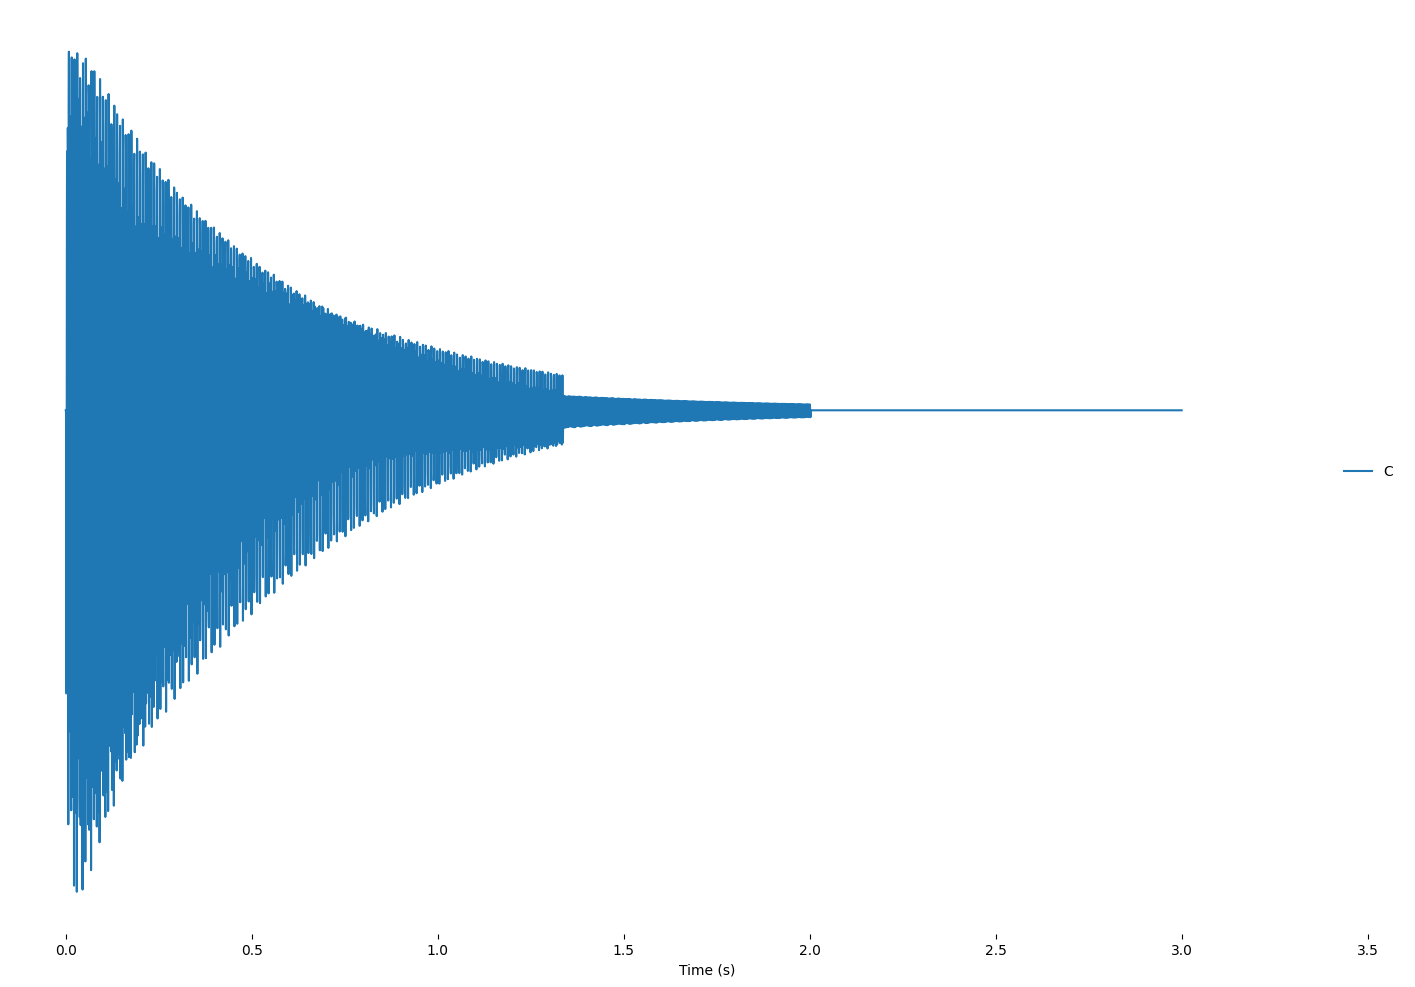

In [7]:
map_values_to_notes_one(fake_matrix)

In [8]:
def map_values_to_notes_one_plus_oct(amplitude_matrix, note_list = np.array(['G','E','C']), inclination = 10,
                                      verbose=0): 
    #this mapping picks octave based on the inclination and then 1) orders the note start by amplitude 2) orders volume by amplitude 
    #this is baking in the assumption that the note_list is sorted low to high 
    a = amplitude_matrix[0,0]
    b = amplitude_matrix[0,1]
    f = amplitude_matrix[2,0] #picking a, b, and f from the traingle matrix
    #feeding in inclination now and turning that into octave - values of 0 thru 90ish
    incs = np.arange(0,90.0001, 13) #
    octaves = np.arange(1, 7.0001, 1)
    #matching to octave
    for i in range(len(incs)):
        if i <= len(incs)-2:
            if incs[i] <= inclination <= incs[i+1]:
                octave = octaves[i]
        else:
            if incs[-1] <= inclination:
                octave = octaves[-1]
        
    j = -1
    note_octave = np.array([])
    for i in note_list:
        j += 1
        note_octave = np.append(note_octave, i+str(int(octave)))

    max_amp = np.max([a, b, f])
    sorted_amplitudes_idx = np.argsort([a, b, f])[::-1] #flip to be highest to lowest
    sorted_scaled = np.sort([a, b, f])[::-1]/max_amp #again flip to be highest to lowest
    note_dict = note_octave[sorted_amplitudes_idx]
    score =  Score([list(note_dict)], length=3) 
    data = {'pitch': np.ones(len(note_dict)), 
           'volume': sorted_scaled}  #volume scaled 0-1
    sources = Events(data)
    sources.fromdict(data)
    #the time limit of the mapping, from 0-101% here. We go above 100% so that we dont just truncate super sharply/the notes can play out
    lims = {'time': ('0','101')}
    sources.apply_mapping_functions(map_lims=lims) 
    #last piece here - putting together the score, sources, generator, and whether it is stereo or audio
    soni = Sonification(score, sources, test1_generator, system)
    #rendering!
    soni.render()
    soni.notebook_display() #currently not saving out, just returning the notebook rendering

100%|██████████| 3/3 [00:00<00:00, 204.12it/s]


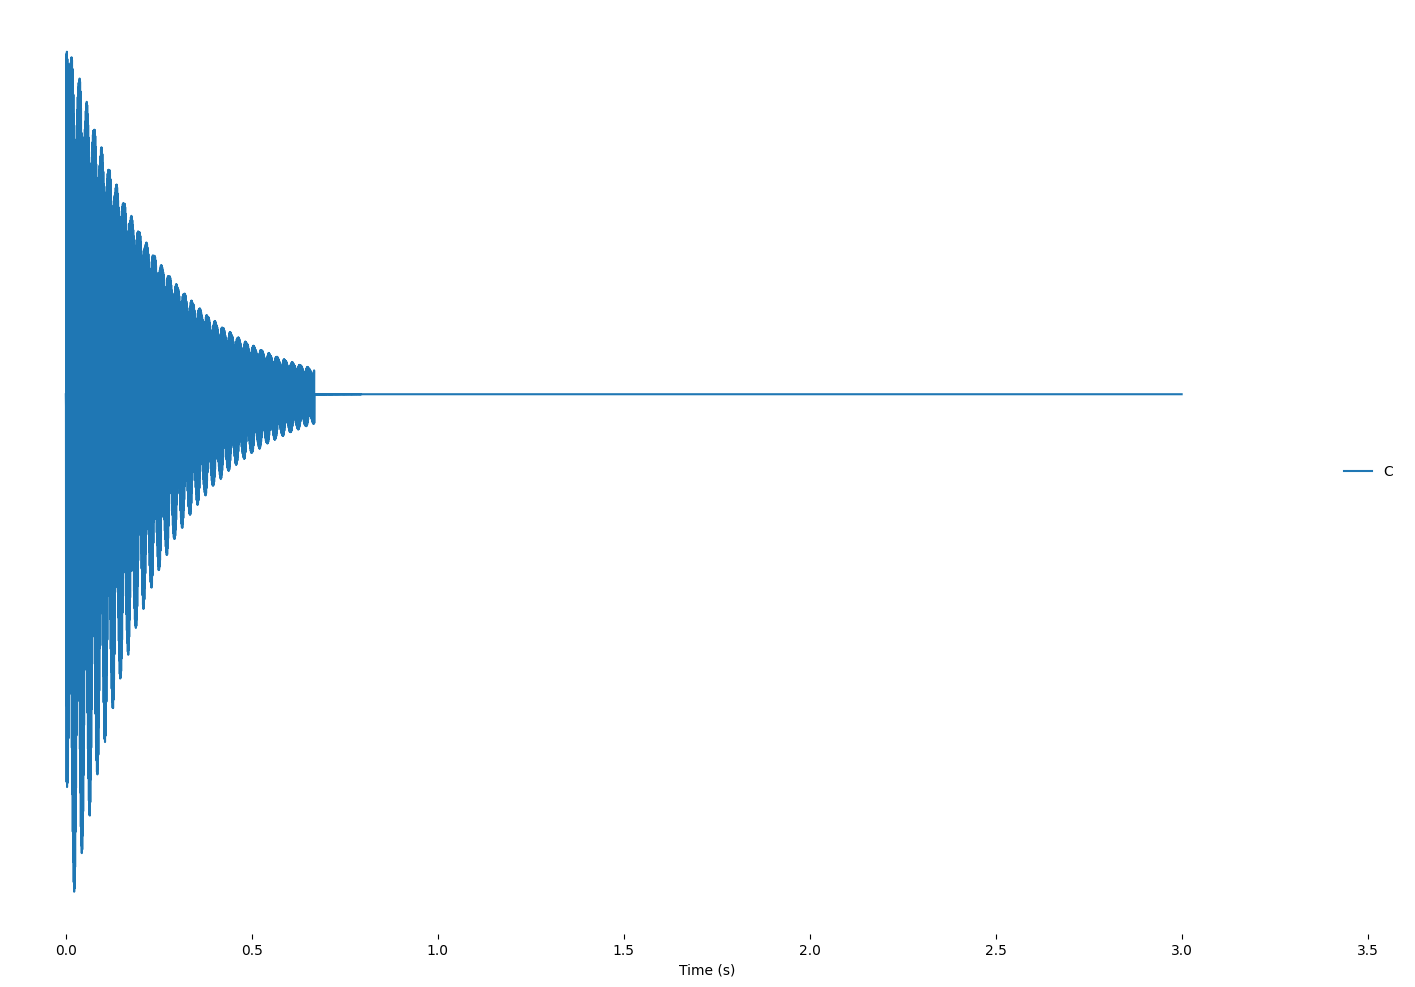

In [9]:
map_values_to_notes_one_plus_oct(fake_matrix, inclination = 62)